In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import load

import os, sys
# local modules
if os.path.exists("../../../src"):
    directory_to_prepend = os.path.abspath("../../../src")
else:
    raise RuntimeError("could not find src dir")
if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

from utils.utils import get_median_from_experiment, get_summary
from utils.swim import backward 
from hamiltonians.index import HenonHeiles
from error_functions.index import l2_error, l2_error_relative, mean_squared_error, mean_absolute_error
from utils.grid import generate_grid
from utils.plot import plot_ground_truth_trajectory_4d, plot_poincare, plot_predicted_trajectory_errors, plot_predicted_trajectory_energy, plot_predicted_trajectories_4d
from integrators.index import SemiImplicitEuler

EXPERIMENT_DIR = '../../../cluster/out/solve-hamil/henon-heiles/r10/alpha-1/1-1/d20000/20000domain[10000]neuronsTrueresampleduplicatesNonenoise_henon_heiles_1_alpha.pkl'

# load experiment
experiment = load(EXPERIMENT_DIR)
print(f"-> LOADED EXPERIMENT: {EXPERIMENT_DIR}")
print(f"                      {experiment.keys()} ")
print(f"                      n_runs = {len(experiment['runs'])} ")
print(f"                      single run includes keys: {experiment['runs'][0].keys()}")
print(f"-> SUMMARY:\n{get_summary(experiment, ['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], ['test'], ['function_errors', 'gradient_errors'], ['l2_error_relative'], ['median', 'mean'])}")
print(f"-> ")
print(f"-> ELM bias min: {np.min(experiment['runs'][0]['ELM'][0].biases)}, max: {np.max(experiment['runs'][0]['ELM'][0].biases)}")

domain_params = experiment['domain_params']
H = experiment['domain_params']['H']
dH = experiment['domain_params']['dH']

print(f"-> DOMAIN PARAMS: {domain_params}")
elm_params = experiment['elm_params']
uswim_params = experiment['uswim_params']
aswim_params = experiment['aswim_params']
swim_params = experiment['swim_params']

print(f"-> ELM PARAMS: {elm_params}")
print(f"-> USWIM PARAMS: {uswim_params}")
print(f"-> ASWIM PARAMS: {aswim_params}")
print(f"-> SWIM PARAMS: {swim_params}")

elm_median_error, _, _, ELM = get_median_from_experiment(EXPERIMENT_DIR, 'ELM', error_function='l2_error_relative') 
uswim_median_error, _, _, USWIM = get_median_from_experiment(EXPERIMENT_DIR, 'U-SWIM', error_function='l2_error_relative') 
aswim_median_error, _, _, ASWIM = get_median_from_experiment(EXPERIMENT_DIR, 'A-SWIM', error_function='l2_error_relative') 
swim_median_error, _, _, SWIM = get_median_from_experiment(EXPERIMENT_DIR, 'SWIM', error_function='l2_error_relative') 

print(f"-> MEDIAN ERRORS")
print(f"- ELM:    {elm_median_error}")
print(f"- U-SWIM: {uswim_median_error}")
print(f"- A-SWIM: {aswim_median_error}")
print(f"- SWIM:   {swim_median_error}")

-> LOADED EXPERIMENT: ../../cluster/out/solve-hamil/henon-heiles/r10/alpha-1/1-1/d20000/20000domain[10000]neuronsTrueresampleduplicatesNonenoise_henon_heiles_1_alpha.pkl
                      dict_keys(['domain_params', 'elm_params', 'uswim_params', 'aswim_params', 'swim_params', 'runs']) 
                      n_runs = 10 
                      single run includes keys: dict_keys(['train_random_seed', 'test_random_seed', 'model_random_seed', 'train_function_errors', 'train_gradient_errors', 'test_function_errors', 'test_gradient_errors', 'train_times', 'ELM', 'U-SWIM', 'A-SWIM', 'SWIM'])
-> SUMMARY:
test function_errors median (l2_error_relative)
- ELM   	: 1.470422727580459e-07
- mean time 	: 338.6539521932602
- U-SWIM   	: 5.047450816582432e-09
- mean time 	: 502.23643119335173
- A-SWIM   	: 1.3144227673819568e-08
- mean time 	: 840.4969803333282
- SWIM   	: 1.3144227673819568e-08
- mean time 	: 325.4601587295532
test function_errors mean (l2_error_relative)
- ELM   	: 1.60269520284

# **Ground Truth**

# **Semi-Implicit Euler**

-> using dt 0.001
lim for q1: [-1.0, 1.0]
lim for q2: [-1.0, 1.0]
lim for p1: [-1.0, 1.0]
lim for p2: [-1.0, 1.0]


<Figure size 640x480 with 0 Axes>

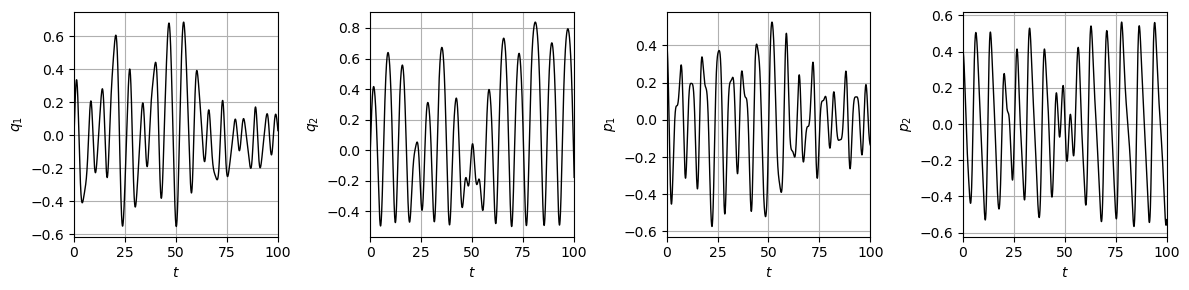

<Figure size 640x480 with 0 Axes>

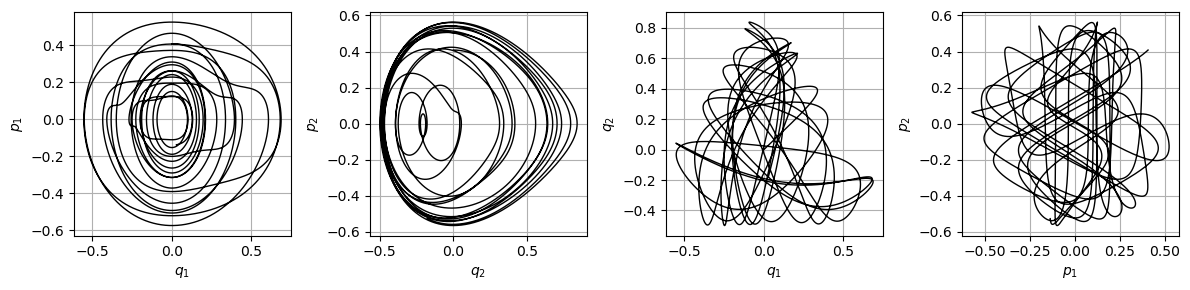

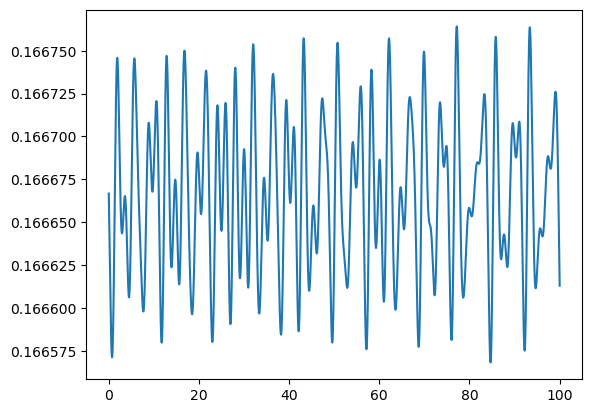

In [2]:
semi_implicit_euler = SemiImplicitEuler()
t_span = [0, 100] 
n_steps = 100000
t_eval = np.linspace(t_span[0], t_span[1], n_steps)
#y0 = [0, 0.3, 0, 0]
y0 = [0., 0., 1/np.sqrt(6), 1/np.sqrt(6)]
#y0 = [0., 0., 0.4, 0.4]
#y0 = [0, np.pi/4, 0, 0]
#y0 = [np.pi/6,np.pi/4,0,0]
#y0 = [0.15, 0.1, -0.05, 0.1]
#y0 = [np.pi/2, np.pi/2, 0, 0]  # JAKOVAC
#y0 = [np.pi*3/7, np.pi*3/8, 0, 0] #CHEN

# use the same params as used in rk45
dt = (t_span[1] - t_span[0]) / n_steps

print(f"-> using dt {dt}")

# t_eval is already defined before while integratin with rk45
traj_true = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_true[-1].reshape(1,-1), dH, dt)
    traj_true = np.append(traj_true, y_next, axis=0)

q1_train_lim_start = experiment['domain_params']['q_train_lim'][0][0]
q1_train_lim_end = experiment['domain_params']['q_train_lim'][0][1]
q2_train_lim_start = experiment['domain_params']['q_train_lim'][1][0]
q2_train_lim_end = experiment['domain_params']['q_train_lim'][1][1]
p1_train_lim_start = experiment['domain_params']['p_train_lim'][0][0]
p1_train_lim_end = experiment['domain_params']['p_train_lim'][0][1]
p2_train_lim_start = experiment['domain_params']['p_train_lim'][1][0]
p2_train_lim_end = experiment['domain_params']['p_train_lim'][1][1]
print(f"lim for q1: [{q1_train_lim_start}, {q1_train_lim_end}]")
print(f"lim for q2: [{q2_train_lim_start}, {q2_train_lim_end}]")
print(f"lim for p1: [{p1_train_lim_start}, {p1_train_lim_end}]")
print(f"lim for p2: [{p2_train_lim_start}, {p2_train_lim_end}]")
if np.any(traj_true[:,0] < q1_train_lim_start):
    #TODO: error print: print("\x1b[31m\"red\"\x1b[0m")
    print(f"\x1b[31m\"WARNING: found q1={np.min(traj_true[:,0])}, which is out of bounds for this experiment\"\x1b[0m")
elif np.any(traj_true[:,0] > q1_train_lim_end):
    print(f"WARNING: found q1={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
if np.any(traj_true[:,1] < q2_train_lim_start):
    print(f"WARNING: found q2={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,1] > q2_train_lim_end):
    print(f"WARNING: found q2={np.max(traj_true[:,1])}, which is out of bounds for this experiment")
if np.any(traj_true[:,2] < p1_train_lim_start):
    print(f"WARNING: found p1={np.min(traj_true[:,2])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,2] > p1_train_lim_end):
    print(f"WARNING: found p1={np.max(traj_true[:,2])}, which is out of bounds for this experiment")
if np.any(traj_true[:,3] < p2_train_lim_start):
    print(f"WARNING: found p2={np.min(traj_true[:,3])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,3] > p2_train_lim_end):
    print(f"WARNING: found p2={np.max(traj_true[:,3])}, which is out of bounds for this experiment")
    
plot_ground_truth_trajectory_4d(t_span, t_eval, traj_true, verbose=True, linewidth=1, save='henon_heiles_ground_truth.pdf')


energy_true = H(traj_true)
plt.clf()
plt.plot(t_eval, energy_true)
plt.show()
#print(f"Double pendulum params are: m1={double_pendulum.m1}, m2={double_pendulum.m2}, l1={double_pendulum.l1}, l2={double_pendulum.l2}, g={double_pendulum.g}")

-> integrating ELM
-> integrating U-SWIM
-> integrating A-SWIM
-> integrating SWIM


<Figure size 640x480 with 0 Axes>

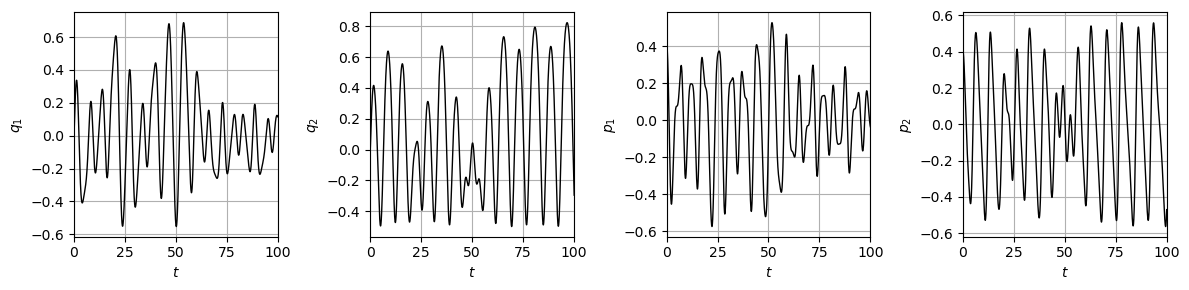

<Figure size 640x480 with 0 Axes>

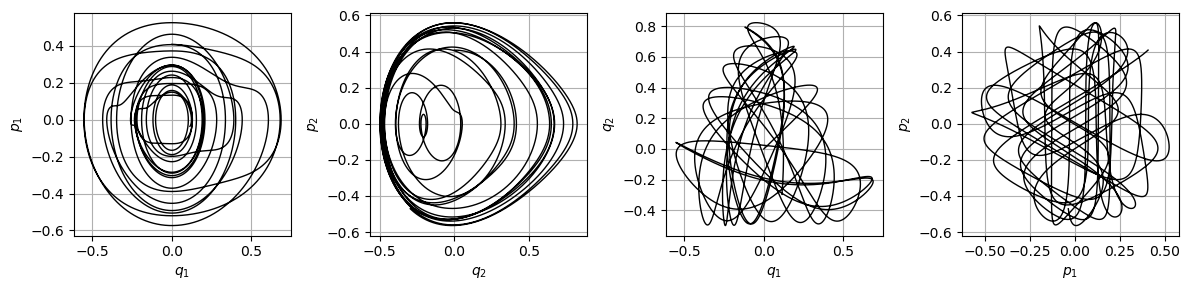

<Figure size 640x480 with 0 Axes>

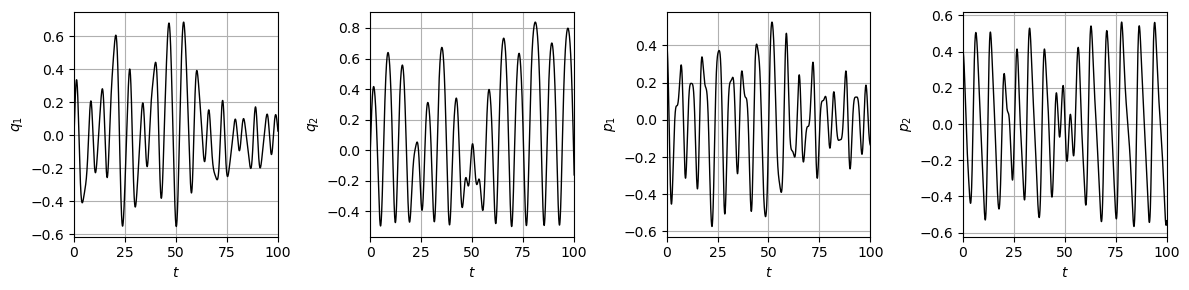

<Figure size 640x480 with 0 Axes>

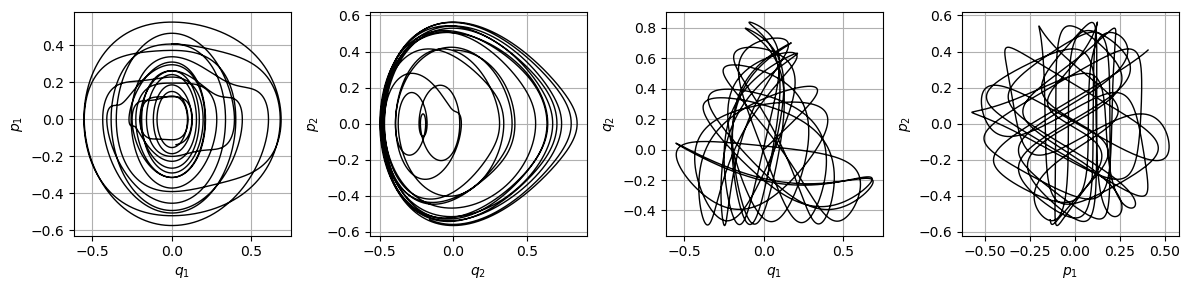

<Figure size 640x480 with 0 Axes>

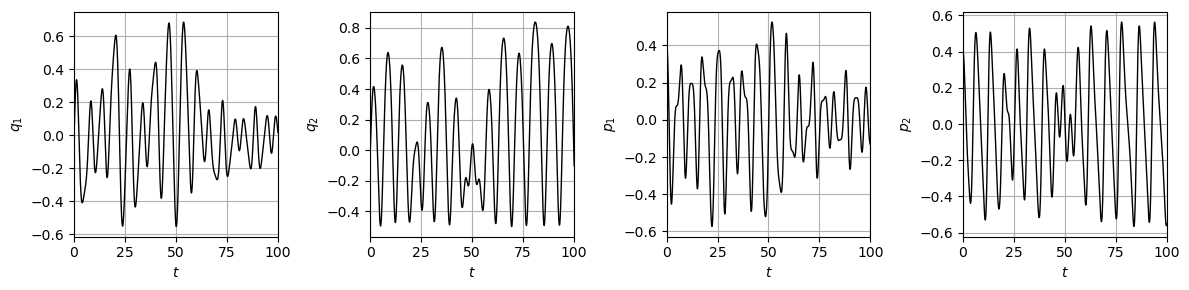

<Figure size 640x480 with 0 Axes>

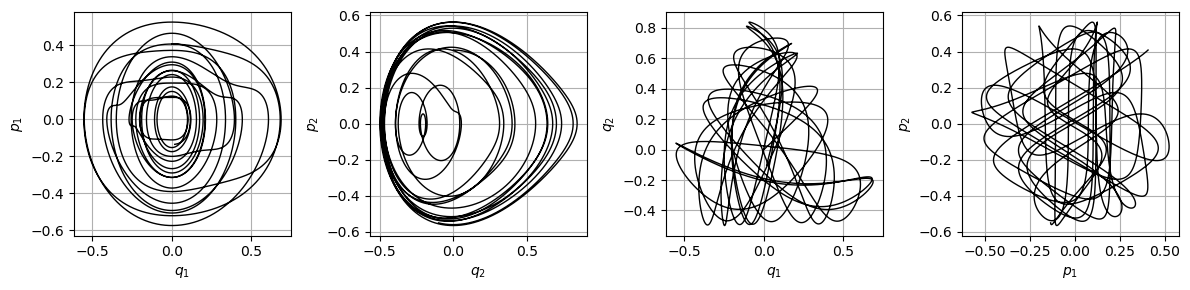

<Figure size 640x480 with 0 Axes>

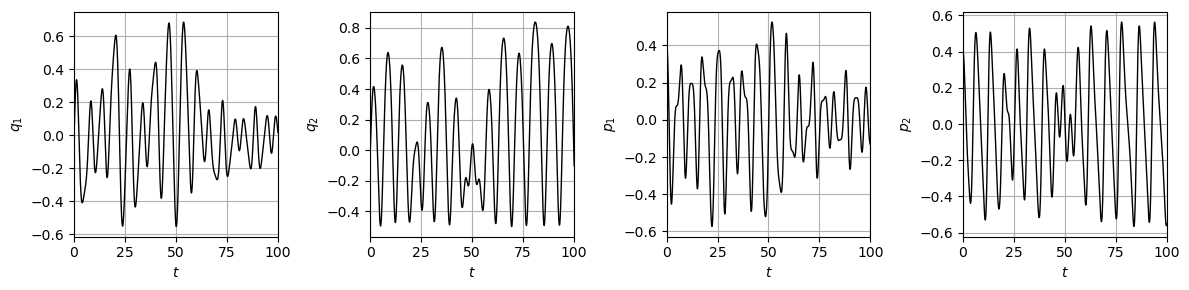

<Figure size 640x480 with 0 Axes>

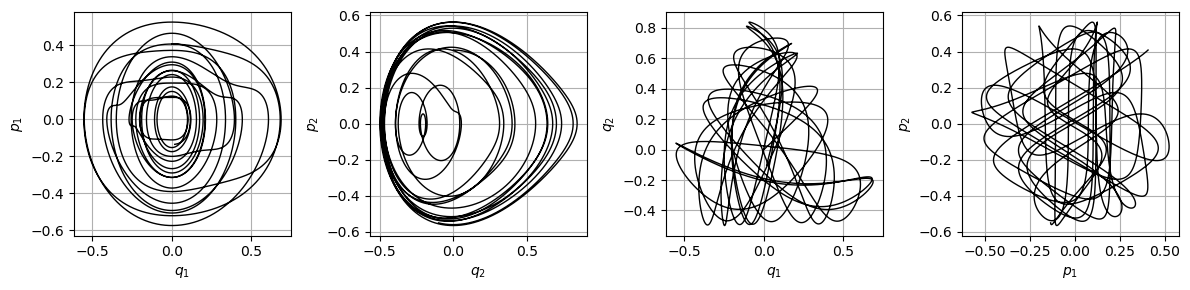

<Figure size 640x480 with 0 Axes>

In [3]:
dH_elm =   lambda x: backward(ELM, elm_params['activation'], x)
dH_uswim = lambda x: backward(USWIM, uswim_params['activation'], x)
dH_aswim = lambda x: backward(ASWIM, aswim_params['activation'], x)
dH_swim = lambda x: backward(SWIM, swim_params['activation'], x)

print(f"-> integrating ELM")
traj_pred_elm = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_elm[-1].reshape(1,-1), dH_elm, dt)
    traj_pred_elm = np.append(traj_pred_elm, y_next, axis=0)
print(f"-> integrating U-SWIM")
traj_pred_uswim = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_uswim[-1].reshape(1,-1), dH_uswim, dt)
    traj_pred_uswim = np.append(traj_pred_uswim, y_next, axis=0)
print(f"-> integrating A-SWIM")
traj_pred_aswim = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_aswim[-1].reshape(1,-1), dH_aswim, dt)
    traj_pred_aswim = np.append(traj_pred_aswim, y_next, axis=0)
print(f"-> integrating SWIM")
traj_pred_swim = np.array([y0])
for i in range(n_steps-1):
    y_next = semi_implicit_euler.step(traj_pred_swim[-1].reshape(1,-1), dH_swim, dt)
    traj_pred_swim = np.append(traj_pred_swim, y_next, axis=0)

plot_ground_truth_trajectory_4d(t_span, t_eval, traj_pred_elm, verbose=True, linewidth=1, save='henon_heiles_elm.pdf')
plot_ground_truth_trajectory_4d(t_span, t_eval, traj_pred_uswim, verbose=True, linewidth=1, save='henon_heiles_uswim.pdf')
plot_ground_truth_trajectory_4d(t_span, t_eval, traj_pred_aswim, verbose=True, linewidth=1, save='henon_heiles_aswim.pdf')
plot_ground_truth_trajectory_4d(t_span, t_eval, traj_pred_swim, verbose=True, linewidth=1, save='henon_heiles_swim.pdf')


<Figure size 640x480 with 0 Axes>

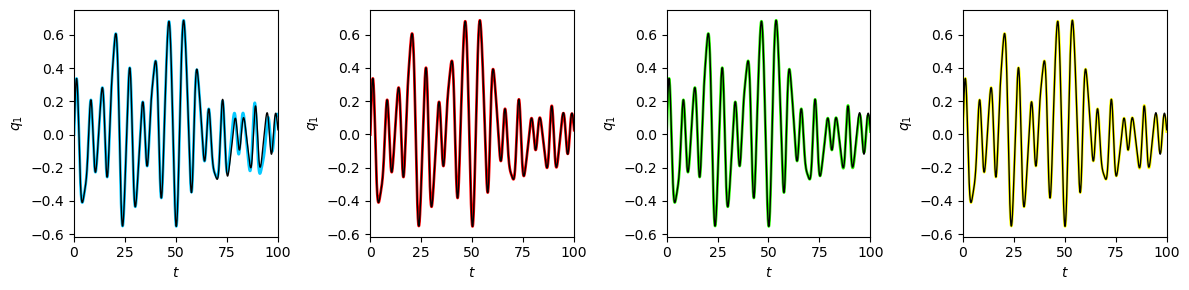

<Figure size 640x480 with 0 Axes>

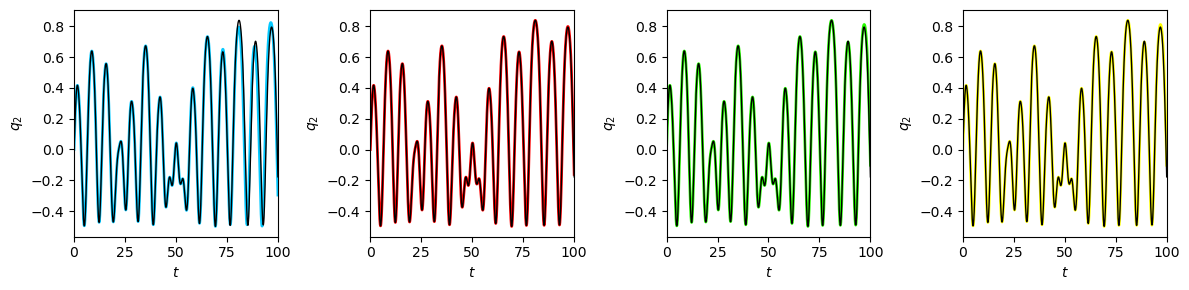

<Figure size 640x480 with 0 Axes>

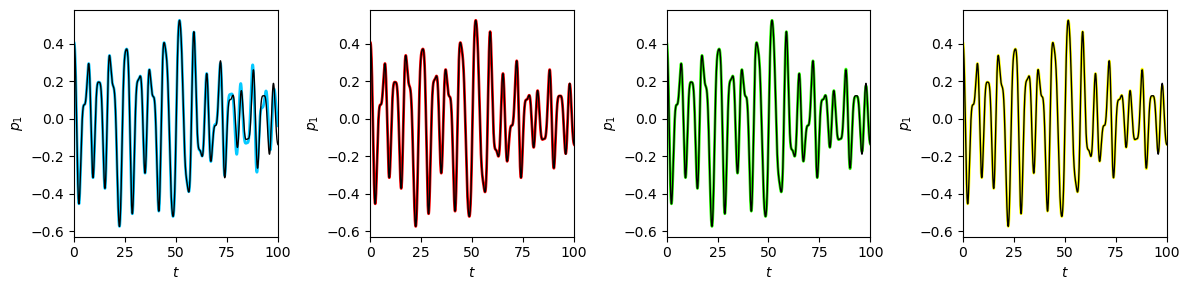

<Figure size 640x480 with 0 Axes>

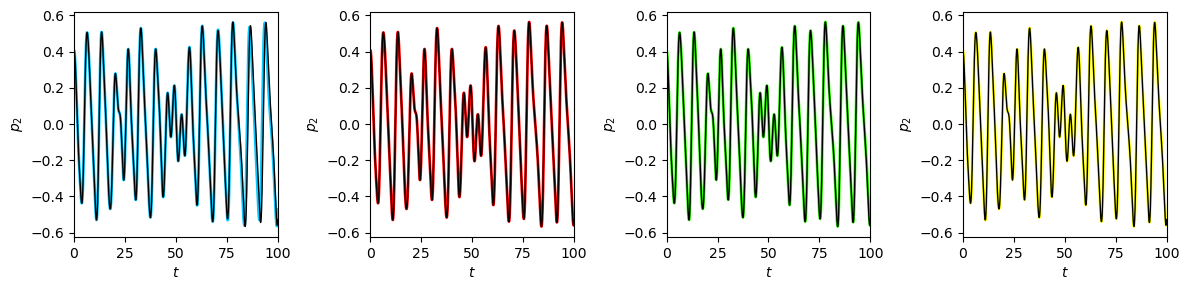

<Figure size 640x480 with 0 Axes>

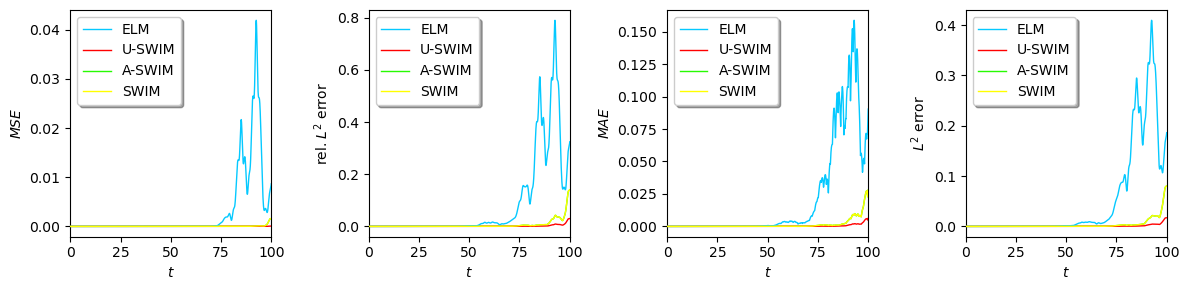

<Figure size 640x480 with 0 Axes>

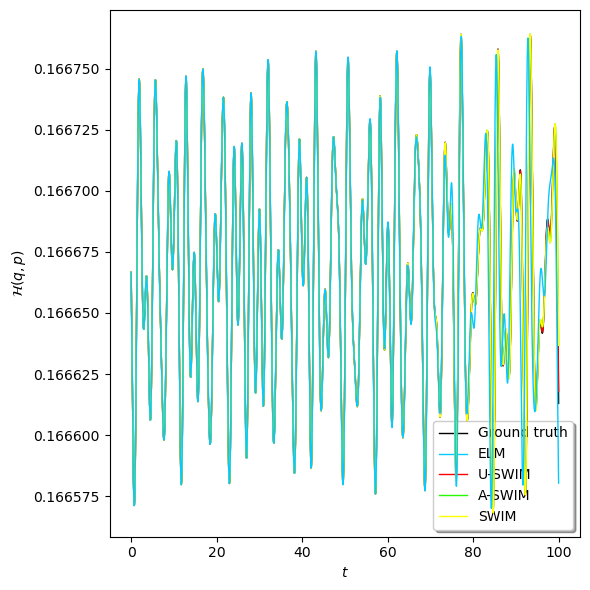

<Figure size 640x480 with 0 Axes>

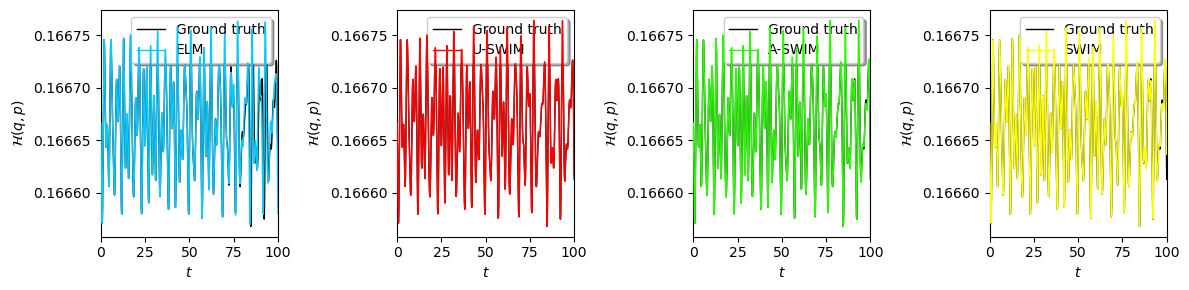

In [4]:
plot_predicted_trajectories_4d(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                               zorders=[2,1,1,1,1], linewidths=[1,2,2,2,2], verbose=True, 
                               save=['henon_heiles_predicted_integration_t_against_q1.pdf', 'henon_heiles_predicted_integration_t_against_q2.pdf', 'henon_heiles_predicted_integration_t_against_p1.pdf', 'henon_heiles_predicted_integration_t_against_p2.pdf'])



plot_predicted_trajectory_errors(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='henon_heiles_predicted_integration_errors.pdf')

# true energies at the predicted trajectories
energy_true = H(traj_true)
energy_elm = H(traj_pred_elm)
energy_uswim = H(traj_pred_uswim)
energy_aswim = H(traj_pred_aswim)
energy_swim = H(traj_pred_swim)


plot_predicted_trajectory_energy(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                 zorders=[2,14,7,8,9], linewidths=[1,1,1,1,1], verbose=True, save='henon_heiles_integration_energies.pdf')